In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
import joblib

# Завантажуємо дані
df = pd.read_csv('../data/dataset_for_modeling.csv', index_col='DateTime', parse_dates=True)
df_daily = df['Global_active_power'].resample('D').sum().to_frame()

# Створюємо часові ознаки
df_daily['day_of_week'] = df_daily.index.dayofweek
df_daily['month'] = df_daily.index.month
df_daily['day_of_year'] = df_daily.index.dayofyear

# Розділяємо X та y, тренувальний та тестовий набори
X = df_daily.drop(columns=['Global_active_power'])
y = df_daily['Global_active_power']
X_train, X_test = X.loc[:'2009-12-31'], X.loc['2010-01-01':]
y_train, y_test = y.loc[:'2009-12-31'], y.loc['2010-01-01':]

In [4]:
# Модель 1: RandomForest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)
preds_rf = rf_model.predict(X_test)
print(f"RandomForest MAE (на денних даних): {mean_absolute_error(y_test, preds_rf):.2f}")

# Модель 2: LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
lgb_model.fit(X_train, y_train)
preds_lgb = lgb_model.predict(X_test)
print(f"LightGBM MAE (на денних даних): {mean_absolute_error(y_test, preds_lgb):.2f}")

RandomForest MAE (на денних даних): 186.47
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 273
[LightGBM] [Info] Number of data points in the train set: 1104, number of used features: 3
[LightGBM] [Info] Start training from score 315.359572
LightGBM MAE (на денних даних): 184.90


In [5]:
# Створюємо список моделей для ансамблю
estimators = [
    ('rf', rf_model),
    ('lgb', lgb_model)
]

# Створюємо та навчаємо VotingRegressor
voting_model = VotingRegressor(estimators=estimators)
voting_model.fit(X_train, y_train)

# Робимо прогноз
preds_voting = voting_model.predict(X_test)
print(f"Voting Ensemble MAE: {mean_absolute_error(y_test, preds_voting):.2f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 273
[LightGBM] [Info] Number of data points in the train set: 1104, number of used features: 3
[LightGBM] [Info] Start training from score 315.359572
Voting Ensemble MAE: 183.55


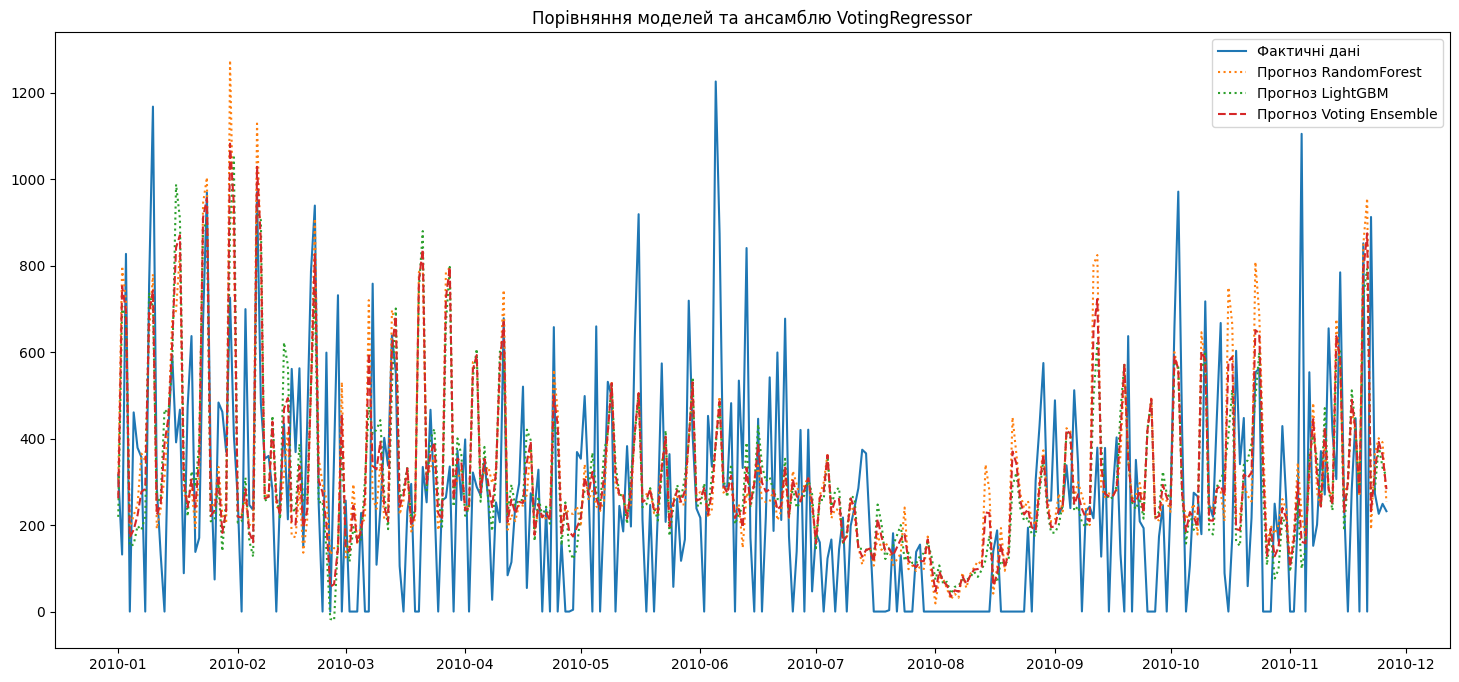

In [6]:
from matplotlib import pyplot as plt

plt.figure(figsize=(18, 8))
plt.plot(y_test, label='Фактичні дані')
plt.plot(y_test.index, preds_rf, label='Прогноз RandomForest', linestyle=':')
plt.plot(y_test.index, preds_lgb, label='Прогноз LightGBM', linestyle=':')
plt.plot(y_test.index, preds_voting, label='Прогноз Voting Ensemble', linestyle='--')
plt.title('Порівняння моделей та ансамблю VotingRegressor')
plt.legend()
plt.show()

In [7]:
joblib.dump(voting_model, '../models/voting_model.pkl')
print("Модель VotingRegressor успішно збережена в 'models/voting_model.pkl'")

Модель VotingRegressor успішно збережена в 'models/voting_model.pkl'
